In [13]:
# Import the libraries
import numpy as np
import torch
import pandas
import matplotlib.pyplot as plt
import time
import copy
from zipfile import ZipFile
from scipy.io import arff
import os
import math

In [2]:
# Import the script files
from LogisticRegression import LogisticRegression
from RiceDataset import RiceDataset
from Standardization import Standardization
from CollateFunction import collate_fn
import DataProcessing as DP
import FCNModelAnalysis as FMA

In [ ]:
# Download the data from UCI repository
!wget https://archive.ics.uci.edu/static/public/545/rice+cammeo+and+osmancik.zip

In [3]:
# Get the path to current directory

_CURRENTDIR = os.path.abspath('')

In [4]:
# To unzip the downloaded datafile run the codes in this cell.

#data_fpath = _CURRENTDIR + '/rice+cammeo+and+osmancik.zip'
#with ZipFile(data_fpath) as zobject:
#    zobject.extractall()

In [4]:
# Load the data
datapath = _CURRENTDIR + '/Rice_Cammeo_Osmancik.arff'
ricedata = arff.loadarff(datapath)

In [5]:
# Rice dataset with 7 numerical features containing 2 target classes (Binary classification)
# Features: Area, Perimeter, Major_Axis_Length, Minor_Axis_Length, Eccentricity, Convex_Area, Extent
# Target classes: Cammeo, Osmancik 
ricedata

(array([(15231., 525.57897949, 229.74987793, 85.09378815, 0.928882  , 15617., 0.57289553, b'Cammeo'),
        (14656., 494.31100464, 206.02006531, 91.73097229, 0.89540499, 15072., 0.61543632, b'Cammeo'),
        (14634., 501.12200928, 214.10678101, 87.76828766, 0.91211808, 14954., 0.69325882, b'Cammeo'),
        ...,
        (12437., 442.49899292, 183.57292175, 86.80197906, 0.88114434, 12645., 0.62673855, b'Osmancik'),
        ( 9882., 392.29699707, 161.19398499, 78.21047974, 0.8744061 , 10097., 0.65906364, b'Osmancik'),
        (11434., 404.70999146, 161.07926941, 90.86819458, 0.82569218, 11591., 0.80294943, b'Osmancik')],
       dtype=[('Area', '<f8'), ('Perimeter', '<f8'), ('Major_Axis_Length', '<f8'), ('Minor_Axis_Length', '<f8'), ('Eccentricity', '<f8'), ('Convex_Area', '<f8'), ('Extent', '<f8'), ('Class', 'S8')]),
 Dataset: Rice_Cammeo_Osmancik
 	Area's type is numeric
 	Perimeter's type is numeric
 	Major_Axis_Length's type is numeric
 	Minor_Axis_Length's type is numeric
 	Ecce

In [6]:
# Randomly shuffle the data and define the input array and target array.

ricedata_idx = np.arange(len(ricedata[0]))
np.random.shuffle(ricedata_idx)

ricedata_shuffled = ricedata[0][ricedata_idx]
Xdata = np.array(ricedata_shuffled.tolist())[:, :-1].astype('float')
Tdata = np.array(ricedata_shuffled.tolist())[:, -1:].astype('str')

In [7]:
# Assign 10% of the data as the test set.

test_split = 0.1
ntest = int(test_split * len(ricedata_shuffled))
Xtest = Xdata[:ntest, ...]
Ttest = Tdata[:ntest, ...]

Xrest = Xdata[ntest:, ...]
Trest = Tdata[ntest:, ...]

In [8]:
# Split the remaining data into train set and validation set.
# Prepare train, validation, test dataset and load those into respective dataloaders. 
# Calculate the standardization parameters.

train_data, valid_data = DP.split_data(Xrest, Trest)
Xtrain, Ttrain = train_data
Xvalid, Tvalid = valid_data

st_obj = Standardization(Xtrain)

split_tuples_list = [(Xtrain, Ttrain), (Xvalid, Tvalid), (Xtest, Ttest)]

dataset_list = [RiceDataset(stup, st_obj) for stup in split_tuples_list]

batch_size_list = [32, 32, 32]
shuffle_list = [True, False, False]

trainloader, validloader, testloader = (torch.utils.data.DataLoader(dataset, 
                                                                    batch_size = batch_size, 
                                                                    collate_fn = collate_fn, 
                                                                    shuffle = shuffle) 
                                        for dataset, batch_size, shuffle 
                                        in zip(dataset_list, batch_size_list, shuffle_list))

In [9]:
# Size of train, validation, and test set
Xtrain.shape, Xvalid.shape, Xtest.shape

((2743, 7), (686, 7), (381, 7))

In [10]:
# Define all parameters required for the model and for saving the results of the initial experiments.
# Run the experiments and save the best performing model's states.

preds_list = []
confs_list = []
evaluation_res_list = []

train_error_list = []
train_error_trace_list = []

valid_error_list = []
valid_error_trace_list = []

in_units = Xdata.shape[-1] 
#n_hidden_units_list = [2, 3] 
classes = np.unique(Ttrain)
use_gpu = True

arch_list = [[2, 3], [5, 10], [4, 5, 8], [10, 40, 20], [90, 100]]
lr_list = [0.01, 0.01, 0.001, 0.01, 0.02]
n_epochs_list = [20, 10, 10, 5, 10]

best_vloss = None
states_path = './saved_states/rice_model_states.pth'

for n_hidden_units_list, learning_rate, n_epochs in zip(arch_list, lr_list, n_epochs_list):

    print('|', end=' ')

    logr_model = LogisticRegression(in_units, n_hidden_units_list, classes, use_gpu)
    logr_model.train(trainloader, validloader, learning_rate, n_epochs, best_vloss, states_path = states_path) 
    best_vloss = logr_model.get_best_validation_loss()
    
    train_error_trace, valid_error_trace = logr_model.get_error_trace()
    train_error = train_error_trace[-1]
    valid_error = valid_error_trace[-1]
    train_error_trace_list.append(train_error_trace)
    train_error_list.append(train_error)
    valid_error_trace_list.append(valid_error_trace)
    valid_error_list.append(valid_error)
    
    Y_preds, Y_confs = logr_model.predict(testloader)
    confs_list.append(Y_confs)
    preds_list.append(Y_preds)
    evaluation_res_list.append(logr_model.evaluate(testloader))

| | | | | 

In [11]:
# Show the initial results of the experiments.

pandas.set_option('display.max_colwidth', None)
pandas.DataFrame([arch_list, n_epochs_list, lr_list, train_error_list, valid_error_list, evaluation_res_list], 
                 index = ['Model Arch', 'Epochs', 'lr', 'Tr-loss', 'Val-loss', 'Test Acc']).T

,Model Arch,Epochs,lr,Tr-loss,Val-loss,Test Acc
0,"[2, 3]",20,0.01,0.190645,0.183362,0.91601
1,"[5, 10]",10,0.01,0.191887,0.189469,0.913386
2,"[4, 5, 8]",10,0.001,0.193898,0.183359,0.918635
3,"[10, 40, 20]",5,0.01,0.201368,0.217053,0.913386
4,"[90, 100]",10,0.02,0.226938,0.198745,0.923885


In [12]:
# Best trained model's result (delete this cell?)

checkpoint = torch.load(states_path) 

logr_model_resume = LogisticRegression(*checkpoint['model_args'])

logr_model_resume.nnet.load_state_dict(checkpoint['model_state_dict'])
Y_pred, Y_conf = logr_model_resume.predict(testloader) 
eval_result = logr_model_resume.evaluate(testloader)
print(eval_result)

0.9396325459317585


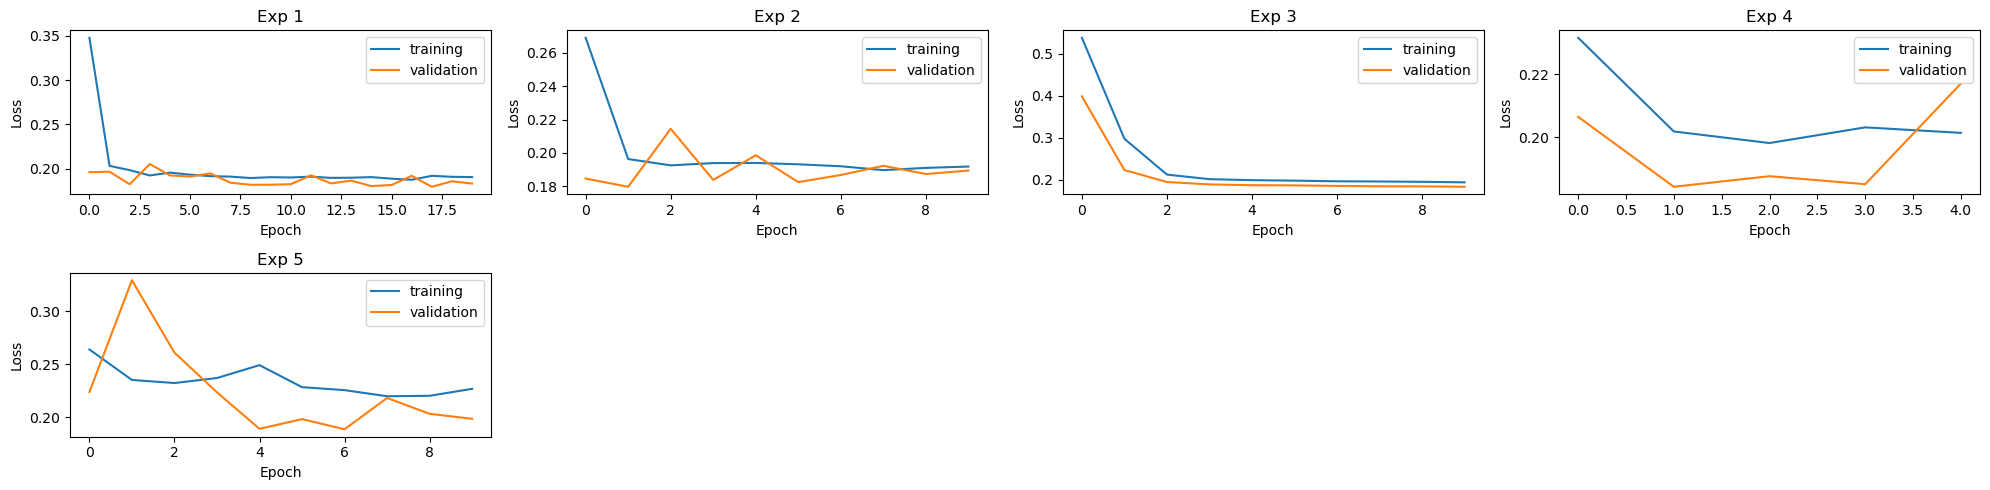

In [14]:
# The loss plots of the experiments.

plt.figure(figsize = (20, 5))
n = len(arch_list)
col = 4 #int(n/4)
row = math.ceil(n/col)
for i in range(n):
    plt.subplot(row, col, i+1)
    plt.plot(train_error_trace_list[i], label = 'training')
    plt.plot(valid_error_trace_list[i], label = 'validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Exp {i+1}')
plt.tight_layout()

In [40]:
# Choose the network with better result, change anything needed, and train longer.

states_path = './saved_states/rice_model_states.pth'

checkpoint = torch.load(states_path)
#best_idx = np.argmax(evaluation_res_list)
best_args = checkpoint['model_args']
n_epochs = checkpoint['epoch']
learning_rate = checkpoint['loss']

in_units, n_hidden_units_list, classes, use_gpu = best_args

learning_rate = 0.01
n_epochs = 500

# Specify a new path for saving the states of this trial.
best_vloss = None
states_path = './saved_states/rice_model_states_trial.pth'

logr_model = LogisticRegression(in_units, n_hidden_units_list, classes, use_gpu)
    

# Now either load the trained model's states and retrain (uncomment the following line)
#logr_model.nnet.load_state_dict(checkpoint['model_state_dict'])

logr_model.train(trainloader, validloader, learning_rate, n_epochs, best_vloss = best_vloss, states_path = states_path) 
best_vloss = logr_model.get_best_validation_loss()
print(f'Best validation loss: {best_vloss:.3f}')

train_error_trace, valid_error_trace = logr_model.get_error_trace()

Y_preds, Y_confs = logr_model.predict(testloader)
Test_acc = logr_model.evaluate(testloader)
print(f'Test Accuracy: {Test_acc:.3f}')

Best validation loss: 0.165
Test Accuracy: 0.927


We do not see much improvement even after training for 300 epochs. The model seems to converge at around epoch 30.

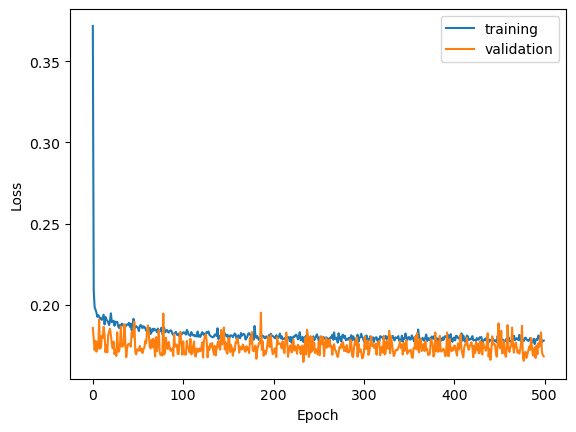

In [41]:
# Loss vs Epoch plot of the above trained model.

plt.plot(train_error_trace, label = 'training')
plt.plot(valid_error_trace, label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

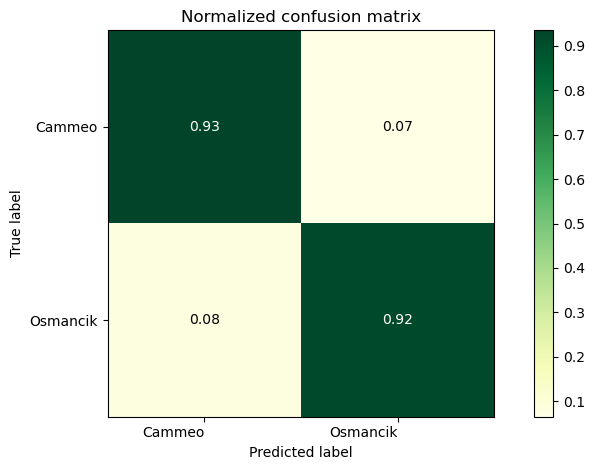

In [42]:
# Add confusion matrix on test set

Pte, Prte = logr_model.predict(testloader) #nnet.use(Xtenn)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
FMA.plot_confusion_matrix(Ttest, Pte, classes=np.unique(Ttest),
                      title='Normalized confusion matrix')

plt.show()

In [3]:
# Do some plotting (learning curve, weights visualization, CM, ROC) and add brief description.

In [43]:
# Use the preferred trained model to test on a different set of samples (rerun the dataloader cell to get a different set).
# Use either './saved_states/rice_model_states.pth' or './saved_states/rice_model_states_trial.pth'

reuse_states_path = './saved_states/rice_model_states_trial.pth'
checkpoint = torch.load(reuse_states_path) 

logr_model_reload = LogisticRegression(*checkpoint['model_args'])

logr_model_reload.nnet.load_state_dict(checkpoint['model_state_dict'])
Y_pred, Y_conf = logr_model_reload.predict(testloader) 
eval_result = logr_model_reload.evaluate(testloader)
print(f'{eval_result:.4f}')

0.9239


In [ ]:
# This cell needs fix and update.
# Inspect visually the samples and their prediction (on top of each plot) by the model.
# Fix this to add some plots to visualize wrongly predicted samples and correctly predicted samples. (or maybe the statistics of them?)
# implement numpy array of test sample input in the model.

#plt.figure(figsize = (16, 10))
#row = 5
#col = 10
#total = int(row * col)
#rand_ind = np.random.randint(0, len(inferset), total)
#for i in range(total):
#    plt.subplot(row, col, i+1)
#    img = plt.imread(test_dir + '/' + inferset[rand_ind[i]])
#    plt.imshow(img)
#    plt.title(label = infer_Y_pred[rand_ind[i]])
#    plt.axis('off');